In [ ]:
!pip install tensorflow_datasets

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D,MaxPool2D,Flatten,Dense,Dropout,BatchNormalization
from tensorflow.keras.models import Sequential

In [ ]:
dataset,info=tfds.load('cats_vs_dogs',with_info=True,as_supervised=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/23262 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cats_vs_dogs/4.0.1.incompleteGH7SFV/cats_vs_dogs-train.tfrecord*...:   0%|…

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.1. Subsequent calls will reuse this data.


In [ ]:
class_names=info.features['label'].names
class_names

['cat', 'dog']

In [ ]:
for i ,example in enumerate(dataset['train']):
    image,label=example
    save_dir='./cats_vs_dogs/train/{}'.format(class_names[label])
    os.makedirs(save_dir,exist_ok=True)

    filename=save_dir+"/"+"{}_{}.jpg".format(class_names[label],i)
    tf.keras.preprocessing.image.save_img(filename,image.numpy())

In [ ]:
datagen=ImageDataGenerator(rescale=1/255,validation_split=0.2,rotation_range=10,
                           width_shift_range=0.1,height_shift_range=0.1,
                          shear_range=0.1,zoom_range=0.10,horizontal_flip=True)

train_generator=datagen.flow_from_directory('./cats_vs_dogs/train',
                                           target_size=(150,150),
                                           batch_size=128,
                                           class_mode='binary',
                                           subset='training')

validation_generator=datagen.flow_from_directory('./cats_vs_dogs/train',
                                           target_size=(150,150),
                                           batch_size=128,
                                           class_mode='binary',
                                           subset='validation')

Found 18611 images belonging to 2 classes.
Found 4651 images belonging to 2 classes.


In [ ]:
#Building CNN
model=Sequential()
#layer 1
model.add(Conv2D(32,kernel_size=3,activation='relu',input_shape=(150,150,3)))
model.add(MaxPool2D(2))
model.add(BatchNormalization())
model.add(Dropout(0.2))

#layer 2
model.add(Conv2D(64,kernel_size=3,activation='relu'))
model.add(MaxPool2D(2))
model.add(BatchNormalization())
model.add(Dropout(0.2))

#layer 3
model.add(Conv2D(128,kernel_size=3,activation='relu'))
model.add(MaxPool2D(2))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dropout(0.5))#it keep neurons for next iteration not completely drop
model.add(Dense(512,activation='relu'))
model.add(Dense(1,activation='sigmoid'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 32)        0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 74, 74, 32)        128       
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 74, 74, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 36, 36, 64)        0

In [ ]:
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

history=model.fit(train_generator,epochs=10,validation_data=validation_generator)

Epoch 1/10
146/146 [==============================] - 175s 1s/step - loss: 2.0363 - accuracy: 0.6254 - val_loss: 1.2285 - val_accuracy: 0.5014
Epoch 2/10
146/146 [==============================] - 164s 1s/step - loss: 0.5683 - accuracy: 0.7117 - val_loss: 1.4741 - val_accuracy: 0.5023
Epoch 3/10
146/146 [==============================] - 166s 1s/step - loss: 0.5170 - accuracy: 0.7441 - val_loss: 1.4933 - val_accuracy: 0.5263
Epoch 4/10
146/146 [==============================] - 166s 1s/step - loss: 0.4889 - accuracy: 0.7640 - val_loss: 0.6789 - val_accuracy: 0.6571
Epoch 5/10
146/146 [==============================] - 166s 1s/step - loss: 0.4694 - accuracy: 0.7784 - val_loss: 0.6228 - val_accuracy: 0.7214
Epoch 6/10
146/146 [==============================] - 167s 1s/step - loss: 0.4554 - accuracy: 0.7858 - val_loss: 0.5473 - val_accuracy: 0.7239
Epoch 7/10
146/146 [==============================] - 166s 1s/step - loss: 0.4338 - accuracy: 0.7960 - val_loss: 0.5956 - val_accuracy: 0.7491

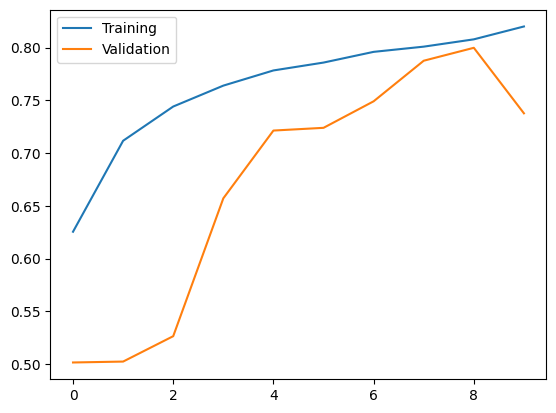

In [ ]:
history.history

plt.plot(history.history['accuracy'],label='Training')
plt.plot(history.history['val_accuracy'],label='Validation')
plt.legend(['Training','Validation'])

In [ ]:
model.save('cats_vs_dogs.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
model_load=tf.keras.models.load_model('cats_vs_dogs.h5')

In [ ]:
import requests
from PIL import Image
from tensorflow.keras.preprocessing import image

img_url="https://cdn.pixabay.com/photo/2020/06/30/22/34/dog-5357794_640.jpg"
img=Image.open(requests.get(img_url,stream=True).raw).resize((150,150))
image_array=image.img_to_array(img)
img=np.expand_dims(image_array,axis=0)
img=img/255
prediction=model.predict(img)
TH=0.5
prediction=int(prediction[0][0]>TH)
classes={v:k for k,v in train_generator.class_indices.items()}
classes[prediction]


1/1 [==============================] - 0s 18ms/step


'dog'